# original, Korquad의 Answer EDA

In [5]:
import json
import os

from datasets import Dataset, load_from_disk, load_dataset
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# train_dataset을 불러오고 싶은 경우
from datasets import load_from_disk
original = load_from_disk("../../data/train_dataset/")
original

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

In [6]:
korquad = load_dataset("squad_kor_v1")
korquad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})

In [13]:
# answer 개수, answer test의 길이
def answer_num(examples):
    count = []
    length = []
    for ex in examples['answers']:
        count.append(len(ex['text']))
        length.append(len(ex['text'][0]))
    # Count the number of UNK tokens for each example
    return {'answer_count': count, 'answer_length': length}

In [14]:
tr_org = original['train'].map(answer_num, batched=True)
val_org = original['validation'].map(answer_num, batched=True)
tr_korquad = korquad['train'].map(answer_num, batched=True)
val_korquad = korquad['validation'].map(answer_num, batched=True)

Map:   0%|          | 0/3952 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60407 [00:00<?, ? examples/s]

Map:   0%|          | 0/5774 [00:00<?, ? examples/s]

### 다중 답안 없이 모두 Answer는 1개입니다

In [ ]:
print(max(tr_org['answer_count']), max(val_org['answer_count']), max(tr_korquad['answer_count']), max(val_korquad['answer_count'])) # 다중 답안 없이 모두 1개임을 확인 가능

### Answer 길이 분포

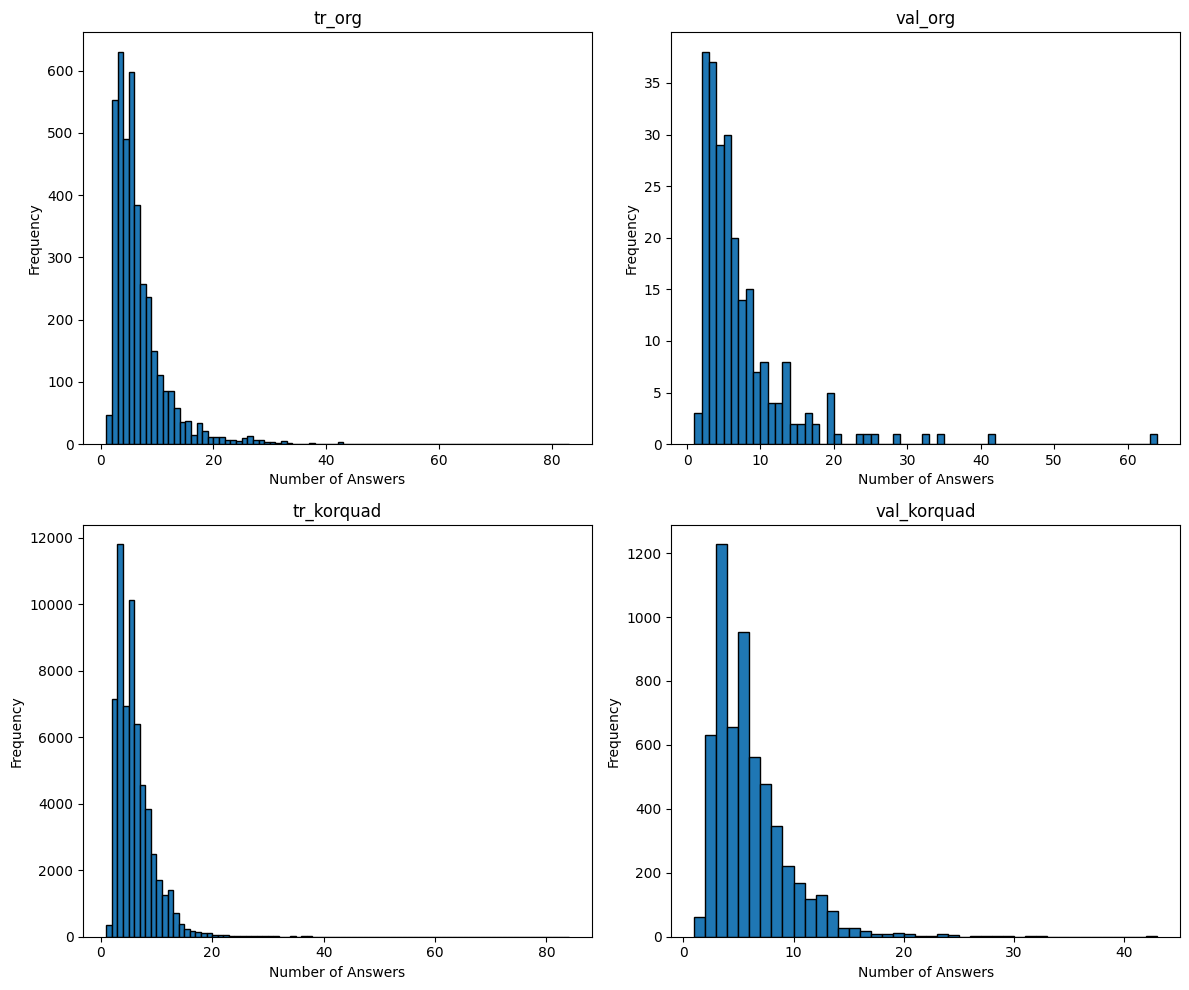

In [18]:
# 데이터셋과 라벨을 묶음으로 저장
length_dict = {
    'tr_org': tr_org['answer_length'],
    'val_org': val_org['answer_length'],
    'tr_korquad': tr_korquad['answer_length'],
    'val_korquad': val_korquad['answer_length']
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, (label, data) in enumerate(length_dict.items()):
    row = idx // 2  # 행 인덱스 (0 또는 1)
    col = idx % 2   # 열 인덱스 (0 또는 1)
    
    axes[row, col].hist(data, bins=range(min(data), max(data) + 1), edgecolor='black')
    axes[row, col].set_title(label)
    axes[row, col].set_xlabel('Number of Answers')
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### UNK가 포함된 Answer 확인해보기

In [19]:
def find_unk_in_answers(examples):
    a = []
    for ex in examples['answers']:
        a.append(ex['text'][0])
    tokenized = tokenizer(a, padding=False, truncation=False)
    # Count the number of UNK tokens for each example
    return [tokenizer.unk_token_id in tokens for tokens in tokenized['input_ids']]

In [21]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

/shared/home/sw_innovation01/anaconda3/envs/odqa/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
tr_org_filtered = tr_org.filter(find_unk_in_answers, batched=True)
val_org_filtered = val_org.filter(find_unk_in_answers, batched=True)
tr_korquad_filtered = tr_korquad.filter(find_unk_in_answers, batched=True)
val_korquad_filtered = val_korquad.filter(find_unk_in_answers, batched=True)

Filter:   0%|          | 0/3952 [00:00<?, ? examples/s]

Filter:   0%|          | 0/240 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60407 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5774 [00:00<?, ? examples/s]

In [24]:
print([len(x) for x in [tr_org_filtered, val_org_filtered, tr_korquad_filtered, val_korquad_filtered]])

[68, 10, 574, 38]


In [25]:
tr_org_filtered['answers']

[{'answer_start': [580], 'text': ['우전왕(優塡王)식 착의법']},
 {'answer_start': [340], 'text': ['벵골 분할령']},
 {'answer_start': [202], 'text': ['‘전의식’(前意識)']},
 {'answer_start': [314], 'text': ['햣켄 해자']},
 {'answer_start': [509], 'text': ['나구모 주이치(南雲忠一) 중장']},
 {'answer_start': [572], 'text': ['괭이갈매기']},
 {'answer_start': [987], 'text': ['노릉(魯陵)']},
 {'answer_start': [400], 'text': ['탑신(塔身)']},
 {'answer_start': [72], 'text': ['쾰른 대주교(안노 2세)']},
 {'answer_start': [720], 'text': ['편도(片刀)']},
 {'answer_start': [775], 'text': ['도스토옙스키가 침대 누워 구술한 것을 아내 안나가 속기 하여']},
 {'answer_start': [1280], 'text': ['아버스놋']},
 {'answer_start': [1813], 'text': ['진리(陳理)']},
 {'answer_start': [707], 'text': ['군의(軍毅)']},
 {'answer_start': [412], 'text': ['석총(釋總)']},
 {'answer_start': [714], 'text': ['‘∧’ 모양']},
 {'answer_start': [786], 'text': ['맬컴 글레이저']},
 {'answer_start': [229], 'text': ['안휘도독 장쉰(張勳)']},
 {'answer_start': [517], 'text': ['파울 그레브너(Paul Gräbner) SS대위']},
 {'answer_start': [235], 'text': ['송공사(宋公祠)']},


In [26]:
val_org_filtered['answers']

[{'answer_start': [70], 'text': ["'진전(陳田)'이라 새겨진 기와조각"]},
 {'answer_start': [212], 'text': ['가오슝 시']},
 {'answer_start': [135], 'text': ['홋카이도']},
 {'answer_start': [104], 'text': ['흑색육(黑色肉)']},
 {'answer_start': [0], 'text': ['제서지전(齊西之戰)이후']},
 {'answer_start': [33], 'text': ['여정현(呂正鉉)']},
 {'answer_start': [335], 'text': ['트레뻬제 부대']},
 {'answer_start': [524], 'text': ['트르피미로비치 왕조(Trpimirović) 출신의 문치미르']},
 {'answer_start': [592], 'text': ['양당(楊黨)']},
 {'answer_start': [491], 'text': ['물적 성과(物的成果)']}]

In [27]:
tr_korquad_filtered['answers'][:100]

[{'text': ['한스 폰 뷜로'], 'answer_start': [402]},
 {'text': ['한스 폰 뷜로'], 'answer_start': [402]},
 {'text': ['한스 폰 뷜로'], 'answer_start': [402]},
 {'text': ['브레븀'], 'answer_start': [125]},
 {'text': ['방사성 넵투늄 족'], 'answer_start': [152]},
 {'text': ['일본자동차공업회(日本自動車工業会)'], 'answer_start': [267]},
 {'text': ['미오넴'], 'answer_start': [189]},
 {'text': ['미오넴'], 'answer_start': [189]},
 {'text': ['이바녜즈 델 캄포'], 'answer_start': [256]},
 {'text': ['펭귄'], 'answer_start': [313]},
 {'text': ['펭귄'], 'answer_start': [313]},
 {'text': ['에스파뇰'], 'answer_start': [209]},
 {'text': ['토트넘 홋스퍼'], 'answer_start': [379]},
 {'text': ['토트넘 홋스퍼'], 'answer_start': [423]},
 {'text': ['맬컴 글레이저'], 'answer_start': [625]},
 {'text': ['맬컴 엑스'], 'answer_start': [182]},
 {'text': ['석탑대동제(石塔大同祭)'], 'answer_start': [10]},
 {'text': ['에미넴'], 'answer_start': [135]},
 {'text': ['에미넴'], 'answer_start': [135]},
 {'text': ['에미넴'], 'answer_start': [135]},
 {'text': ['12.5 ‰'], 'answer_start': [9]},
 {'text': ['구테호프눙스테'], 'answer_start

In [28]:
val_korquad_filtered['answers']

[{'text': ['종홍산(鐘洪山)'], 'answer_start': [281]},
 {'text': ['칭짱(青藏)고원'], 'answer_start': [0]},
 {'text': ['치롄 산맥'], 'answer_start': [203]},
 {'text': ['치롄 산맥(Qilian Range)'], 'answer_start': [203]},
 {'text': ['조선콤퓨터쎈터'], 'answer_start': [117]},
 {'text': ['조선콤퓨터쎈터(조선컴퓨터센터)'], 'answer_start': [117]},
 {'text': ['유흠(劉歆)'], 'answer_start': [80]},
 {'text': ['경초력(景初曆)'], 'answer_start': [499]},
 {'text': ['조충지(祖沖之)'], 'answer_start': [72]},
 {'text': ['대명력(大明曆)'], 'answer_start': [334]},
 {'text': ['수시력(授時曆)'], 'answer_start': [69]},
 {'text': ['데먄스크 근방'], 'answer_start': [17]},
 {'text': ['데먄스크 근방'], 'answer_start': [17]},
 {'text': ['쉘 위 댄스'], 'answer_start': [355]},
 {'text': ['윈저트 앤 뷸리'], 'answer_start': [20]},
 {'text': ['뉘르부르크링(Nürburgring)'], 'answer_start': [0]},
 {'text': ['CLICHÈ'], 'answer_start': [27]},
 {'text': ['CLICHÈ'], 'answer_start': [27]},
 {'text': ['CLICHÈ'], 'answer_start': [27]},
 {'text': ['모텟'], 'answer_start': [236]},
 {'text': ['모텟'], 'answer_start': [236]},
 {'